# l1 Trend Filtering

Paper : https://web.stanford.edu/~boyd/papers/pdf/l1_trend_filter.pdf

Baudouin de Monicault baudouin.de-monicault@polytechnique.edu

Thomas Li thomas.li9162@gmail.com

In [144]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme()

## create_tests.py

Creating toy time series according section 4. of the paper

In [146]:
import numpy as np


def create_signals(
    N: int,
    signal_length: int,
    max_slope: float,
    p_trend_change: float,
    noise_level: float,
):
    """create N signals of size signal_length that have linear trend
    and changes trend every 1/(1-p) in mean

    output shape : (N, signal_length)
    """
    signals = np.zeros((N, signal_length))
    ## moments where we change the slope
    change_slope = np.random.random((N, signal_length))
    change_slope = change_slope >= p_trend_change
    for k in range(N):
        signals[k][0] = np.random.randn()
        slope = (np.random.random() - 0.5) * 2 * max_slope
        for j in range(1, signal_length):
            if not change_slope[k, j]:
                signals[k, j] = signals[k, j - 1] + slope
            else:
                slope = (np.random.random() - 0.5) * 2 * max_slope
                signals[k, j] = signals[k, j - 1] + slope
    return signals


# def create_multivariate_signals(
#     N: int,
#     signal_length: int,
#     D: int,
#     max_slope: float,
#     p_trend_change: float,
#     noise_level: float,
#     shift: int = 50,
# ):
#     """create N signals of size signal_length that have linear trend
#     and changes trend every 1/(1-p) in mean,
#     the dim of the signal is D
#     and every dimension is just a shift of the 1st dimension
#     """
#     signals = np.zeros((N, D, signal_length))

#     first_signal = create_signals(
#         N, signal_length, max_slope, p_trend_change, noise_level
#     )
#     for k in range(D):
#         signals[:, k, :] = np.roll(first_signal, axis=1, shift=shift * k)
#     signals = np.transpose(signals, (0, 2, 1))
#     return signals


def create_multivariate_signals(
    N: int,
    signal_length: int,
    D: int,
    max_slope: float,
    p_trend_change: float,
    noise_level: float,
    shift: int = 50,
):
    """create N signals of size signal_length that have linear trend
    and changes trend every 1/(1-p) in mean,
    the dim every signal is D
    for every signal, we have one underlying "big" signal
    and on every dimension is just the big signal + a smaller signal

    output shape : (N, signal_length, D)
    """
    signals = np.zeros((N, signal_length, D))

    big_signal = create_signals(
        N, signal_length, max_slope, p_trend_change, noise_level
    )

    signals = np.tile(big_signal, (D, 1, 1))
    signals = np.transpose(signals, (1, 2, 0))
    print(signals.shape)

    for k in range(D):
        small_signal = create_signals(
            N, signal_length, max_slope, p_trend_change, noise_level
        )
        signals[:, :, k] += 0.3 * small_signal
    return signals

## filter.py

trend filtering for the uni-dimensional case

In [148]:
import numpy as np
from scipy.linalg import toeplitz
import cvxpy as cp
import scipy


def Hodrick_Prescott(signal, penalty):
    """
    Hodrick_Prescott_trend_filtering algorithm (benchmark)
    (fast)
    """
    n = len(signal)
    row = np.zeros(n)
    row[:3] = np.array([1, -2, 1])
    col = np.zeros(n - 2)
    col[0] = 1
    D = toeplitz(c=col, r=row)
    filtering_matrix = np.eye(n) + 2 * penalty * D.transpose() @ D
    filtering_matrix = np.linalg.inv(filtering_matrix)
    # closed formula
    filtered = filtering_matrix @ signal
    return filtered


def l1_trend_filter(signal, penalty):
    """
    original l1_trend_filtering algorithm proposed in the paper
    (fast)
    """
    n = len(signal)
    x = cp.Variable(n)
    row = np.zeros(n)
    row[:3] = np.array([1, -2, 1])
    col = np.zeros(n - 2)
    col[0] = 1
    D = toeplitz(c=col, r=row)
    # convex minimizer
    objective = cp.Minimize(
        0.5 * cp.sum_squares(x - signal) + penalty * cp.norm(D @ x, 1)
    )
    prob = cp.Problem(objective=objective)
    prob.solve(solver=cp.CLARABEL)
    return x.value


def l1_trend_filter2(signal, penalty):
    """
    equivalent l1_trend_filtering algorithm proposed in section 3.2
    (slow)
    """
    n = len(signal)
    theta = cp.Variable(n)
    mat_A = compute_matrix_A(n)
    # print(mat_A.shape)
    objective = cp.Minimize(
        0.5 * cp.sum_squares(mat_A @ theta - signal) + penalty * cp.norm(theta[3:], 1)
    )

    prob = cp.Problem(objective=objective)
    prob.solve(solver=cp.CLARABEL)
    return mat_A @ theta.value


def compute_matrix_A(n):
    A_ = np.diag(np.ones(n), 0)
    for k in range(2, n):
        A_ += np.diag(k * np.ones(n - k + 1), -k + 1)
    A_[:, 0] = np.ones(n)
    # A_ = scipy.sparse.dia_array(A_)

    return A_

### Vizualizing filter.py

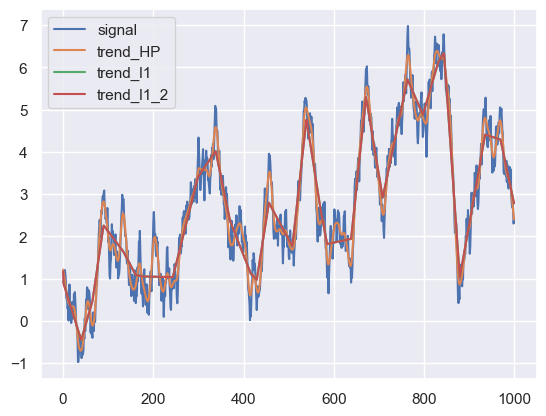

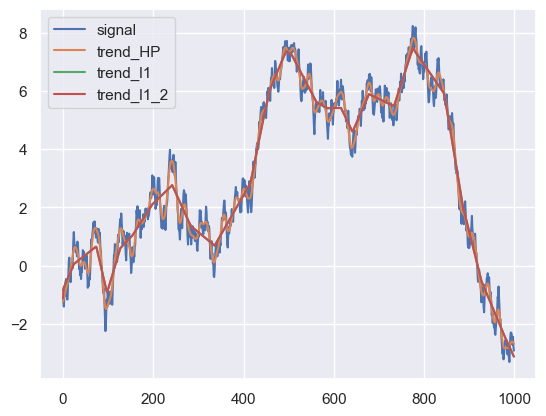

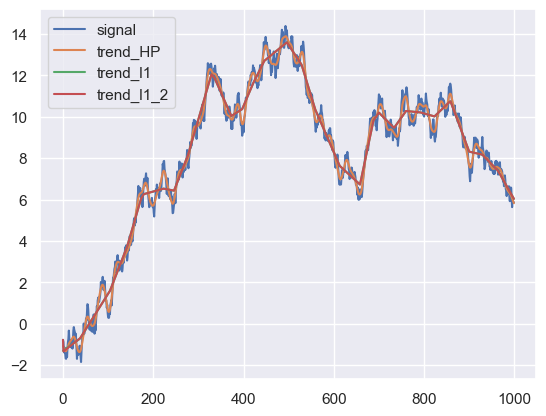

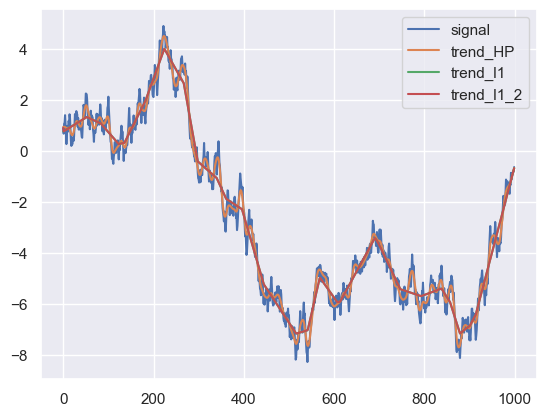

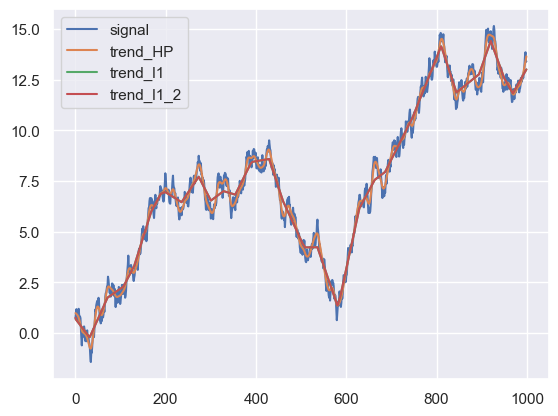

In [128]:
import matplotlib.pyplot as plt

# signals = np.load("./data/signals_test.npy")
signals = create_signals(
    N=10, signal_length=1000, max_slope=0.5, p_trend_change=0.01, noise_level=20
)

for i in range(5):
    signal = signals[i]
    trend_HP = Hodrick_Prescott(signal, penalty=50.0)
    trend_l1 = l1_trend_filter(signal, penalty=50.0)
    trend_l1_2 = l1_trend_filter2(signal, penalty=50.0)
    plt.plot(signal, label="signal")
    plt.plot(trend_HP, label="trend_HP")
    plt.plot(trend_l1, label="trend_l1")
    plt.plot(trend_l1_2, label="trend_l1_2")
    plt.legend()
    plt.show()

## multivariate_filters.py

trend filtering for the multi-dimensional case

In [149]:
import numpy as np
from scipy.linalg import toeplitz

# from filter import compute_matrix_A
# from create_tests import create_multivariate_signals
from tqdm import tqdm
from numba import jit


## formulation 1
## to do : numba compatible toeplitz
# @jit(nopython=False)
def m_focuss(signal: np.ndarray, penalty: float, n_iter: int = 20):
    """
    m_focuss algorithm seened in course 6.
    (slow)
    """
    n = signal.shape[0]
    dim = signal.shape[1]
    row = np.zeros(n)
    row[:3] = np.array([1, -2, 1])
    col = np.zeros(n - 2)
    col[0] = 1
    D = toeplitz(c=col, r=row)
    X = signal  # we copy the signal at the beginning
    for k in tqdm(range(n_iter)):
        W = np.diag(np.sqrt(np.linalg.norm(D @ X, axis=1)))
        W_inv_2 = np.clip(
            np.diag(1 / np.linalg.norm(D @ X, axis=1)), -(10**6), 10**6
        )
        filtering_matrix = np.eye(n) + penalty * D.T @ W_inv_2 @ D
        filtering_matrix = np.linalg.pinv(filtering_matrix)
        filtered = filtering_matrix @ signal

        X = filtered

    return X


def m_focuss_A(signal: np.ndarray, penalty: float, n_iter: int = 20):
    n = signal.shape[0]
    dim = signal.shape[1]
    A = compute_matrix_A(n)
    theta = np.clip(
        np.linalg.pinv(A) @ signal, -0.1, 0.1
    )  # we do some hard thresholding (test)
    P = np.eye(n - 2, n, k=2)  # projector in the space spanned by n-2 last vectors
    AtA = A.T @ A
    Aty = A.T @ signal

    for k in tqdm(range(n_iter)):
        W = np.diag(np.sqrt(np.linalg.norm(P @ theta, axis=1)))
        W_inv_2 = np.clip(
            np.diag(1 / np.linalg.norm(P @ theta, axis=1)), -(10**6), 10**6
        )
        filtering_matrix = AtA + penalty * P.T @ W_inv_2 @ P
        filtering_matrix = np.clip(
            np.linalg.pinv(filtering_matrix), -(10**6), 10**6
        )
        filtered = filtering_matrix @ Aty
        theta = filtered

    return A @ theta


def l1_trend_filter_multivariate(signal, penalty):
    """
    l1_trend_filter_multivariate algorithm described in section 7.5
    (slow)
    """
    n, d = signal.shape
    x = cp.Variable((n, d))
    # convex minimizer
    left = cp.sum_squares(x - signal)
    right = 0
    for t in range(1, n - 1):
        right += cp.norm(x[t - 1] - 2 * x[t] + x[t + 1], 2)
    objective = cp.Minimize(left + penalty * right)
    prob = cp.Problem(objective=objective)
    prob.solve(solver=cp.CLARABEL)
    return x.value

### Vizualizing multivariate_filter.py

(10, 1000, 5)


c:\Users\thoma\AppData\Local\Programs\Python\Python39\lib\site-packages\cvxpy\problems\problem.py:158: UserWarning: Objective contains too many subexpressions. Consider vectorizing your CVXPY code to speed up compilation.
  warnings.warn("Objective contains too many subexpressions. "
100%|██████████| 20/20 [00:11<00:00,  1.71it/s]


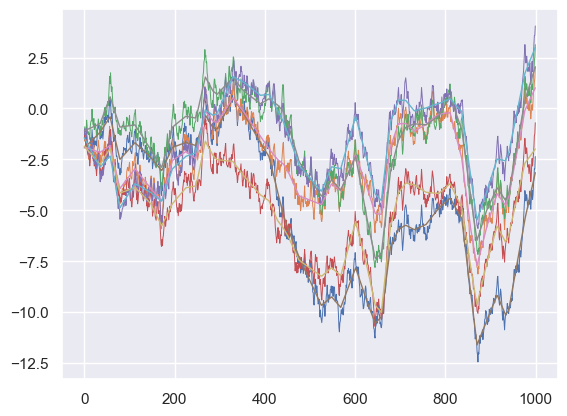

In [141]:
multivariate_signals = create_multivariate_signals(
    N=10,
    signal_length=1000,
    D=5,
    max_slope=0.5,
    p_trend_change=0.01,
    noise_level=20.0,
    shift=20,
)

signal = multivariate_signals[0]
trend_l1 = l1_trend_filter_multivariate(signal, penalty=100)
trend_m_focuss = m_focuss(signal, penalty=100)
plt.plot(multivariate_signals[0], linewidth=0.7)
plt.plot(trend_l1, linewidth=1.0)

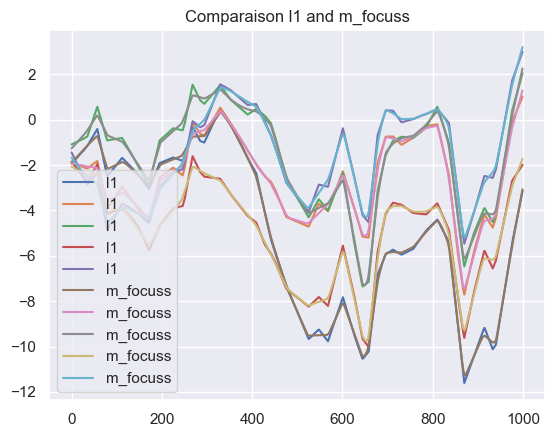

In [143]:
plt.plot(trend_l1, label="l1")
plt.plot(trend_m_focuss, label="m_focuss")
plt.legend()
plt.title("Comparaison l1 and m_focuss")
plt.show()

The two algorithms are equivalent.